In [ ]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade

## Dependencies

In [51]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pymongo
from sklearn.preprocessing import LabelEncoder, StandardScaler, MultiLabelBinarizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from config import mongo_conn

## Load Perfume Data

In [52]:
# Initialize PyMongo to work with MongoDBs
client = pymongo.MongoClient(mongo_conn)
db = client.perfumes_db
perfume_df = pd.DataFrame(list(db.perfume_data_coll.find()))
# drop rows where there is no rating
perfume_df = perfume_df[perfume_df["rating"] != "NA"]
perfume_df = perfume_df.dropna(subset=["rating"])
perfume_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454 entries, 0 to 477
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   _id           454 non-null    object
 1   name          454 non-null    object
 2   company       454 non-null    object
 3   image         454 non-null    object
 4   for_gender    454 non-null    object
 5   rating        454 non-null    object
 6   number_votes  454 non-null    object
 7   main accords  454 non-null    object
 8   description   454 non-null    object
 9   top notes     454 non-null    object
 10  middle notes  454 non-null    object
 11  base notes    454 non-null    object
 12  longevity     454 non-null    object
 13  sillage       454 non-null    object
 14  gender_vote   454 non-null    object
 15  price value   454 non-null    object
dtypes: object(16)
memory usage: 60.3+ KB


## Preprocess Data

### Weighted Rating

In [53]:
# Find the weighted rating taking into consideration both mean rating and number of reviews
# Weighted Rating (WR) = (v ÷ (v+m)) × R + (m ÷ (v+m)) × C  where
# v is the number of votes 
# m is the minimum number of votes required (the prerequisite) 
# R is the mean rating
# C is the mean rating of all the perfumes in the dataset

C = perfume_df["rating"].mean()

# value of m is the number of votes garnered by the 80th percentile perfume
m = perfume_df['number_votes'].quantile(0.80)

# Function to compute the weighted rating for each perfume
def weighted_rating(x, m=m, C=C):
    v = x['number_votes']
    R = x['rating']
    
    # Compute the weighted score
    if v == 0:
        return 0
    else:
        return (v/(v+m) * R) + (m/(m+v) * C)


In [54]:
# Compute the weighted_rating using the weighted_rating function defined above
perfume_df["weighted_rating"] = perfume_df.apply(weighted_rating, axis=1)
perfume_df[["name", "rating", "number_votes", "weighted_rating"]].sort_values(by=['weighted_rating'], ascending=False)

,name,rating,number_votes,weighted_rating
435,Dior Homme Intense 2011,4.49,8172,4.344620
392,La Nuit de l'Homme,4.44,12256,4.343471
407,Aventus,4.42,10486,4.317785
174,The One for Men Eau de Parfum,4.52,4669,4.303598
437,A*Men Pure Havane,4.46,5665,4.291157
...,...,...,...,...
239,Chanel No 5 Parfum,3.69,12257,3.789296
415,Womanity,3.6,8844,3.754604
70,Joy by Dior,3.29,3011,3.750299
413,Lady Million,3.61,10049,3.748637


### MultiLabelBinarizer

In [55]:
# convert Notes list to multiple features columns
mlb = MultiLabelBinarizer()

# Top Notes
X_top_notes = mlb.fit_transform(perfume_df["top notes"])
column_names = ["top_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_top_notes, columns=column_names))

# Middle Notes
X_middle_notes = mlb.fit_transform(perfume_df["middle notes"])
column_names = ["middle_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_middle_notes, columns=column_names))

# Base notes
X_base_notes = mlb.fit_transform(perfume_df["base notes"])
column_names = ["base_note_" + note for note in mlb.classes_]
perfume_df = perfume_df.join(pd.DataFrame(X_base_notes, columns=column_names))

perfume_df.columns

Index(['_id', 'name', 'company', 'image', 'for_gender', 'rating',
       'number_votes', 'main accords', 'description', 'top notes',
       ...
       'base_note_White Sandalwood', 'base_note_White Woods',
       'base_note_Woodsy Notes', 'base_note_Woody Notes', 'base_note_iris',
       'base_note_oak moss', 'base_note_resins', 'base_note_vanilla bean',
       'base_note_vetyver', 'base_note_white honey'],
      dtype='object', length=779)

### DictVectorizer

In [56]:
# convert Accords dict to multiple features columns
dv = DictVectorizer(sparse=False)
X_accords = dv.fit_transform(perfume_df["main accords"])
perfume_df = perfume_df.join(pd.DataFrame(X_accords, columns=dv.feature_names_))
perfume_df.head()


,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,tropical,tuberose,vanilla,violet,vodka,warm spicy,whiskey,white floral,woody,yellow floral
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,0.0,0.0000,78.3058,0.0,0.0,89.4303,0.0,0.000,100.0000,0.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0.0,59.0888,0.0000,0.0,0.0,0.0000,0.0,100.000,0.0000,0.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0.0,0.0000,100.0000,0.0,0.0,0.0000,0.0,69.338,0.0000,0.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,100.0000,0.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0.0,0.0000,0.0000,0.0,0.0,0.0000,0.0,0.000,67.7451,0.0


In [57]:
# convert longevity dict to multiple features columns
dv = DictVectorizer(sparse=False)
X_longevity = dv.fit_transform(perfume_df["longevity"])
column_names = ["longevity_" + note for note in dv.feature_names_]
perfume_df = perfume_df.join(pd.DataFrame(X_longevity, columns=column_names))
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,warm spicy,whiskey,white floral,woody,yellow floral,longevity_eternal,longevity_long lasting,longevity_moderate,longevity_very weak,longevity_weak
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,89.4303,0.0,0.000,100.0000,0.0,78.0,184.0,107.0,21.0,17.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0.0000,0.0,100.000,0.0000,0.0,89.0,216.0,200.0,49.0,84.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0.0000,0.0,69.338,0.0000,0.0,84.0,212.0,103.0,24.0,12.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0.0000,0.0,0.000,100.0000,0.0,77.0,288.0,174.0,125.0,83.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0.0000,0.0,0.000,67.7451,0.0,35.0,221.0,188.0,59.0,66.0


In [58]:
# convert sillage dict to multiple features columns
dv = DictVectorizer(sparse=False)
X_sillage = dv.fit_transform(perfume_df["sillage"])
column_names = ["sillage_" + note for note in dv.feature_names_]
perfume_df = perfume_df.join(pd.DataFrame(X_sillage, columns=column_names))
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,yellow floral,longevity_eternal,longevity_long lasting,longevity_moderate,longevity_very weak,longevity_weak,sillage_enormous,sillage_intimate,sillage_moderate,sillage_strong
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,0.0,78.0,184.0,107.0,21.0,17.0,79.0,40.0,187.0,157.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,0.0,89.0,216.0,200.0,49.0,84.0,221.0,127.0,322.0,251.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,0.0,84.0,212.0,103.0,24.0,12.0,131.0,39.0,155.0,237.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,0.0,77.0,288.0,174.0,125.0,83.0,151.0,214.0,370.0,189.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,0.0,35.0,221.0,188.0,59.0,66.0,106.0,115.0,333.0,183.0


In [59]:
# convert gender vote dict to multiple features columns
dv = DictVectorizer(sparse=False)
X_gender_vote = dv.fit_transform(perfume_df["gender_vote"])
perfume_df = perfume_df.join(pd.DataFrame(X_gender_vote, columns=dv.feature_names_))
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,longevity_weak,sillage_enormous,sillage_intimate,sillage_moderate,sillage_strong,female,male,more female,more male,unisex
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,17.0,79.0,40.0,187.0,157.0,40.0,20.0,39.0,51.0,226.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,84.0,221.0,127.0,322.0,251.0,349.0,0.0,21.0,0.0,4.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,12.0,131.0,39.0,155.0,237.0,162.0,2.0,91.0,8.0,70.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,83.0,151.0,214.0,370.0,189.0,3.0,199.0,1.0,56.0,17.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,66.0,106.0,115.0,333.0,183.0,3.0,151.0,0.0,71.0,5.0


In [60]:
# convert price value dict to multiple features columns
dv = DictVectorizer(sparse=False)
X_price_value = dv.fit_transform(perfume_df["price value"])
perfume_df = perfume_df.join(pd.DataFrame(X_price_value, columns=dv.feature_names_))
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,female,male,more female,more male,unisex,good value,great value,ok,overpriced,way overpriced
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,40.0,20.0,39.0,51.0,226.0,27.0,11.0,98.0,143.0,64.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,349.0,0.0,21.0,0.0,4.0,26.0,8.0,125.0,121.0,38.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,162.0,2.0,91.0,8.0,70.0,35.0,6.0,136.0,59.0,11.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,3.0,199.0,1.0,56.0,17.0,33.0,3.0,134.0,59.0,31.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,3.0,151.0,0.0,71.0,5.0,21.0,4.0,80.0,84.0,32.0


In [61]:
# replace empty values with 0
perfume_df = perfume_df.fillna(0)
perfume_df.head()

,_id,name,company,image,for_gender,rating,number_votes,main accords,description,top notes,...,female,male,more female,more male,unisex,good value,great value,ok,overpriced,way overpriced
0,603c1b01630c8404c6d21a56,Angels' Share,By Kilian,https://fimgs.net/mdimg/perfume/375x500.62615.jpg,for women and men,4.31,682,"{'woody': 100.0, 'sweet': 92.6987, 'warm spicy...",Angels' Share by By Kilian is a Oriental Vanil...,[Cognac],...,40.0,20.0,39.0,51.0,226.0,27.0,11.0,98.0,143.0,64.0
1,603c1b01630c8404c6d21a57,My Way,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.62036.jpg,for women,3.57,1471,"{'white floral': 100.0, 'citrus': 60.4322, 'tu...",My Way by Giorgio Armani is a Floral fragrance...,"[Orange Blossom, Bergamot]",...,349.0,0.0,21.0,0.0,4.0,26.0,8.0,125.0,121.0,38.0
2,603c1b01630c8404c6d21a58,Libre Intense,Yves Saint Laurent,https://fimgs.net/mdimg/perfume/375x500.62318.jpg,for women,4.02,858,"{'vanilla': 100.0, 'aromatic': 71.4216, 'sweet...",Libre Intense by Yves Saint Laurent is a Orien...,"[Lavender, Mandarin Orange, Bergamot]",...,162.0,2.0,91.0,8.0,70.0,35.0,6.0,136.0,59.0,11.0
3,603c1b01630c8404c6d21a59,Dior Homme 2020,Christian Dior,https://fimgs.net/mdimg/perfume/375x500.58714.jpg,for men,3.42,1402,"{'woody': 100.0, 'musky': 72.7229, 'amber': 53...",Dior Homme 2020 by Christian Dior is a Woody f...,"[Bergamot, Pink Pepper, elemi]",...,3.0,199.0,1.0,56.0,17.0,33.0,3.0,134.0,59.0,31.0
4,603c1b01630c8404c6d21a5a,Acqua di Giò Profondo,Giorgio Armani,https://fimgs.net/mdimg/perfume/375x500.59532.jpg,for men,4.03,869,"{'aromatic': 100.0, 'marine': 93.2493, 'citrus...",Acqua di Giò Profondo by Giorgio Armani is a A...,"[Sea Notes, Aquozone, Bergamot, Green Mandarin]",...,3.0,151.0,0.0,71.0,5.0,21.0,4.0,80.0,84.0,32.0


### X (data) and y (target)

In [62]:
# drop unnecessary columns
X = perfume_df.drop(["_id", "name", "company", "image", "for_gender", "rating", "number_votes", "main accords", "description", "top notes", "middle notes", "base notes", "longevity", "sillage", "gender_vote", "price value", "weighted_rating"], axis=1)
y = perfume_df["weighted_rating"].values.reshape(-1, 1)
print(X.shape, y.shape)
X.head()

(454, 847) (454, 1)


,top_note_African Orange flower,top_note_Agarwood (Oud),top_note_Aldehydes,top_note_Almond,top_note_Almond Blossom,top_note_Amalfi Lemon,top_note_Amber,top_note_Ambrette (Musk Mallow),top_note_Angelica,top_note_Anise,...,female,male,more female,more male,unisex,good value,great value,ok,overpriced,way overpriced
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.0,20.0,39.0,51.0,226.0,27.0,11.0,98.0,143.0,64.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,349.0,0.0,21.0,0.0,4.0,26.0,8.0,125.0,121.0,38.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,162.0,2.0,91.0,8.0,70.0,35.0,6.0,136.0,59.0,11.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,199.0,1.0,56.0,17.0,33.0,3.0,134.0,59.0,31.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,151.0,0.0,71.0,5.0,21.0,4.0,80.0,84.0,32.0


array([[<AxesSubplot:title={'center':'top_note_African Orange flower'}>,
        <AxesSubplot:title={'center':'top_note_Agarwood (Oud)'}>,
        <AxesSubplot:title={'center':'top_note_Aldehydes'}>,
        <AxesSubplot:title={'center':'top_note_Almond'}>,
        <AxesSubplot:title={'center':'top_note_Almond Blossom'}>,
        <AxesSubplot:title={'center':'top_note_Amalfi Lemon'}>,
        <AxesSubplot:title={'center':'top_note_Amber'}>,
        <AxesSubplot:title={'center':'top_note_Ambrette (Musk Mallow)'}>,
        <AxesSubplot:title={'center':'top_note_Angelica'}>,
        <AxesSubplot:title={'center':'top_note_Anise'}>,
        <AxesSubplot:title={'center':'top_note_Apple'}>,
        <AxesSubplot:title={'center':'top_note_Apricot'}>,
        <AxesSubplot:title={'center':'top_note_Aquozone'}>,
        <AxesSubplot:title={'center':'top_note_Artemisia'}>,
        <AxesSubplot:title={'center':'top_note_Asafoetida'}>,
        <AxesSubplot:title={'center':'top_note_Bamboo'}>,
       

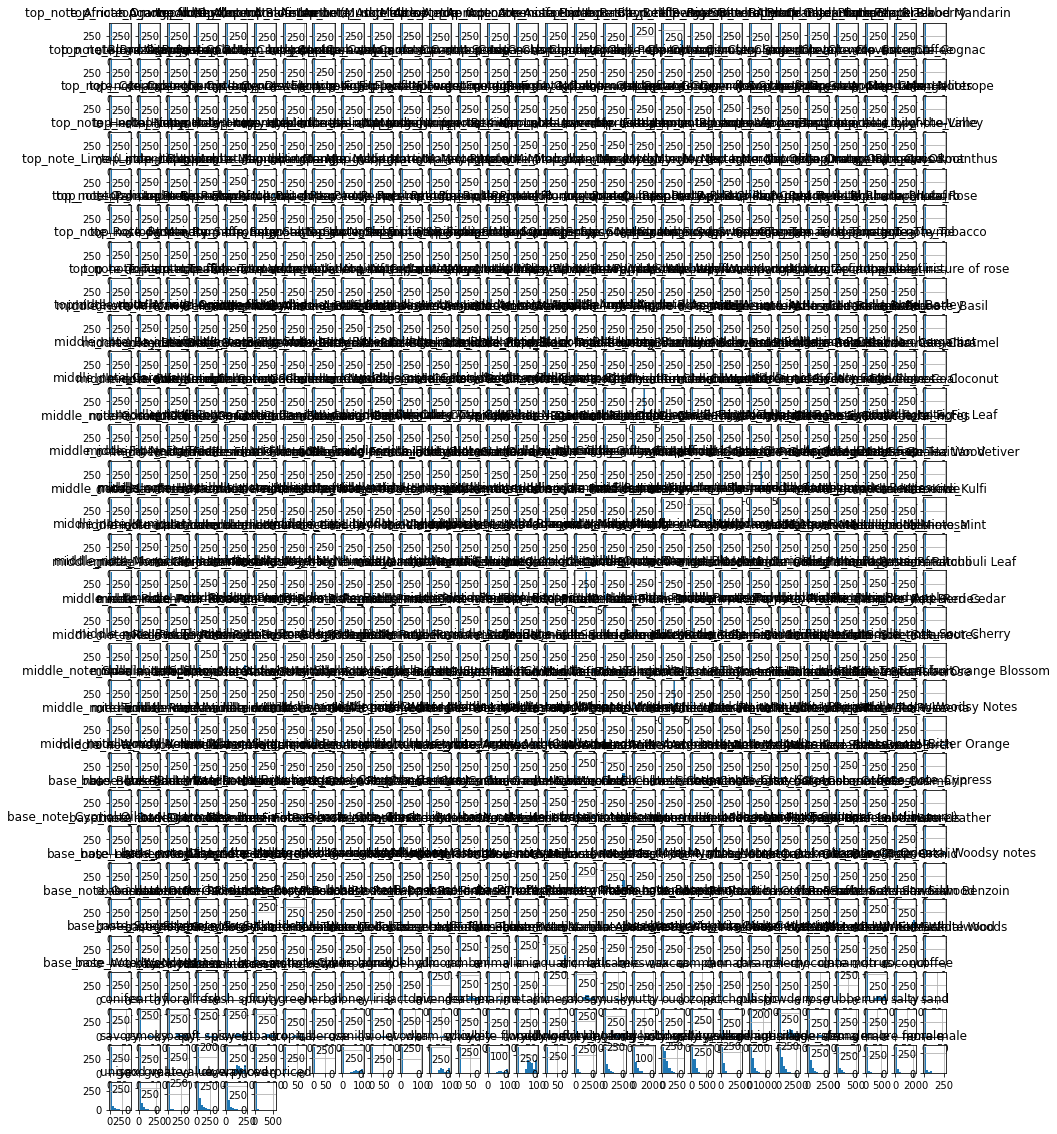

In [63]:
X.hist(figsize=(15,20))

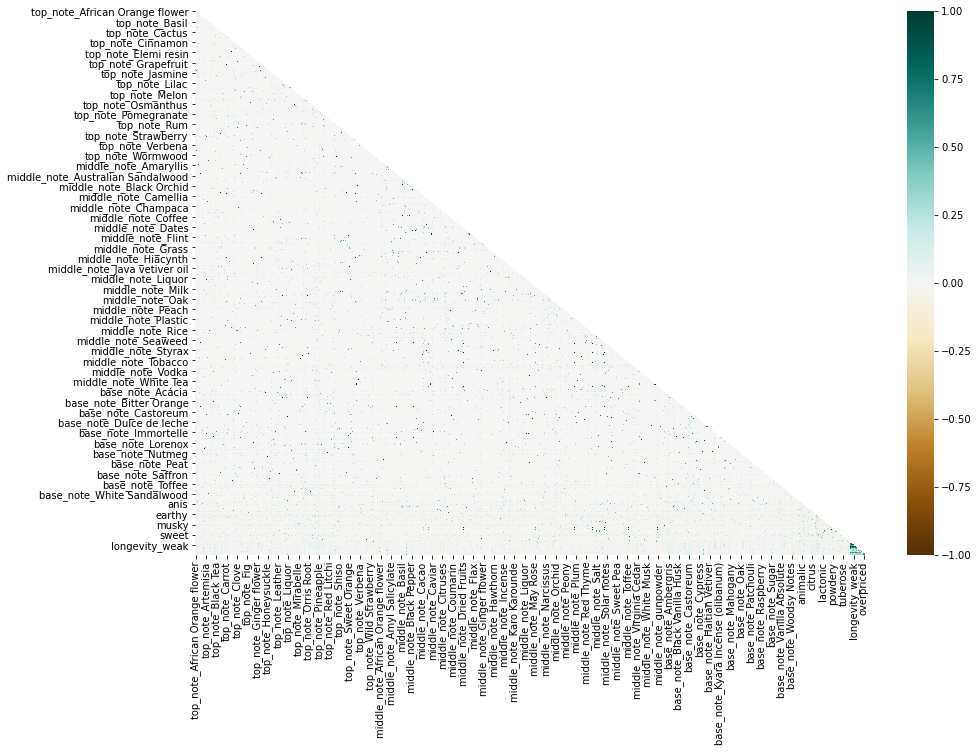

In [64]:
# heatmap to figure best features. Features that are more green are highly correlated and thus not a good option
plt.figure(figsize=(15,10))
mask = np.triu(np.ones_like(X.corr(), dtype=np.bool))
heatmap = sns.heatmap(X.corr(), mask=mask, vmin=-1, vmax=1, cmap="BrBG")

## Train and Test data

In [65]:
# Split the data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [66]:
# Create a StandardScater model and fit it to the training data

X_scaler = StandardScaler().fit(X_train)
y_scaler = StandardScaler().fit(y_train)

In [67]:
# Transform the training and testing data using the X_scaler and y_scaler models

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)
y_train_scaled = y_scaler.transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

## Linear Regression Model

In [68]:
# Create a LinearRegression model and fit it to the scaled training data

model = LinearRegression()
model.fit(X_train_scaled, y_train_scaled)


LinearRegression()

8208243371331.715
Feature: 0, Score: 168164478916.23309
Feature: 1, Score: -77197264378.62589
Feature: 2, Score: 2551445946890.15186
Feature: 3, Score: -660911490419.20471
Feature: 4, Score: 547398095302.23077
Feature: 5, Score: 2478196405108.60791
Feature: 6, Score: -502704673142.45349
Feature: 7, Score: 276947745239.97644
Feature: 8, Score: -243485087030.30646
Feature: 9, Score: 1302670559706.60181
Feature: 10, Score: -35127655256.11065
Feature: 11, Score: 836972147905.78247
Feature: 12, Score: 1360418609931.35425
Feature: 13, Score: -2446443665791.53809
Feature: 14, Score: 427384241223.01270
Feature: 15, Score: -371570885366.74542
Feature: 16, Score: -206508266880.58047
Feature: 17, Score: 376065013515.60571
Feature: 18, Score: 1086513282417.94177
Feature: 19, Score: -672117118040.61621
Feature: 20, Score: 768539655387.66821
Feature: 21, Score: -476459634657.78400
Feature: 22, Score: 157680052282.22415
Feature: 23, Score: 568748207489.35852
Feature: 24, Score: -561056273541.26892
Fe

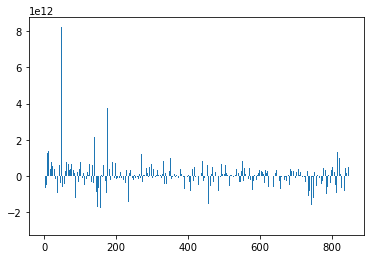

In [69]:
# summarize feature importance
importance = model.coef_[0]
print(max(importance))
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()


### Mean Squared Error and R2

In [70]:
# Used X_test_scaled, y_test_scaled, and model.predict(X_test_scaled) to calculate MSE and R2
predictions = model.predict(X_test_scaled)
MSE = mean_squared_error(y_test_scaled, predictions)
r2 = model.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 2.0141400944208345e+26, R2: -2.0405955283650003e+26


### Lasso Model

In [71]:
lasso = Lasso(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = lasso.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = lasso.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.3360562955957285, R2: -0.3536051985601887


### Ridge Model

In [72]:
ridge = Ridge(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = ridge.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = ridge.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.8651095989425186, R2: -0.8896075392447507


### ElasticNet model

In [73]:
elasticnet = ElasticNet(alpha=.01).fit(X_train_scaled, y_train_scaled)

predictions = elasticnet.predict(X_test_scaled)

MSE = mean_squared_error(y_test_scaled, predictions)
r2 = elasticnet.score(X_test_scaled, y_test_scaled)

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1.3473022793004543, R2: -0.36499889660706053


##### Save the Model

In [74]:
import joblib
final_model = lasso
filename = '../webapp/static/Resources/popular_perfume_model.sav'
joblib.dump(final_model, filename)

['../webapp/static/Resources/popular_perfume_model.sav']